<a href="https://colab.research.google.com/github/Amadou794545/Prediction_de_risque_de_credit_bancaire/blob/main/Prediction_de_risque_de_cr%C3%A9dit_bancaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Objectif : Évaluer la probabilité qu'un client fasse défaut sur un prêt.**

Import

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

print("Path to dataset files:", path)

100%|██████████| 0.98M/0.98M [00:00<00:00, 36.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1


In [ ]:
print(os.listdir('/root/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1'))


['UCI_Credit_Card.csv']


In [ ]:
df1 = pd.read_csv('/root/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1/UCI_Credit_Card.csv', delimiter=',')
df1.dataframeName = 'UCI_Credit_Card.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1.head()
df1["default.payment.next.month"].value_counts()

There are 30000 rows and 25 columns


,count
default.payment.next.month,
0,23364
1,6636


#Nettoyage des données



30000 ligne pour 25 colonnes



In [ ]:
df1.shape

(30000, 25)

In [ ]:
df1.columns
df1.head()
df1.columns
df1.rename(columns = {'default.payment.next.montht':'default_payment_next_month'}, inplace = True)
df1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [ ]:
#reformatage des données brutes
def FormattageRawData():
  data_file = "/root/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1/UCI_Credit_Card.csv"

  # Charger le fichier de données dans un DataFrame Pandas
  data = pd.read_csv(data_file)

  # Lire les données brutes
  raw_data = data
  # Renommer les noms de colonne
  raw_data.columns = raw_data.columns.str.lower().str.replace(" ", "_")
  months = ["sep", "aug", "jul", "jun", "may", "apr"]
  variables = ["payment_status", "bill_statement", "previous_payment"]
  new_column_names = [x + "_" + y for x in variables for y in months]
  rename_dict = {x: y for x, y in zip(raw_data.loc[:, "pay_0":"pay_amt6"].columns, new_column_names)}
  raw_data.rename(columns=rename_dict, inplace=True)

  # Mapper les nombres aux chaines de caractères
  gender_dict = {1: "Male",
                2: "Female"}
  education_dict = {0: "Others",
                    1: "Graduate school",
                    2: "University",
                    3: "High school",
                    4: "Others",
                    5: "Others",
                    6: "Others"}
  marital_status_dict = {0: "Others",
                        1: "Married",
                        2: "Single",
                        3: "Others"}
  payment_status = {-2: "Unknown",
                    -1: "Payed duly",
                    0: "Unknown",
                    1: "Payment delayed 1 month",
                    2: "Payment delayed 2 months",
                    3: "Payment delayed 3 months",
                    4: "Payment delayed 4 months",
                    5: "Payment delayed 5 months",
                    6: "Payment delayed 6 months",
                    7: "Payment delayed 7 months",
                    8: "Payment delayed 8 months",
                    9: "Payment delayed >= 9 months"}
  default_payment_next_month_dict = {0: 0,
                                     1: 1}
  raw_data["sex"] = raw_data["sex"].map(gender_dict)
  raw_data["education"] = raw_data["education"].map(education_dict)
  raw_data["marriage"] = raw_data["marriage"].map(marital_status_dict)
  raw_data["default_payment_next_month"] = raw_data["default.payment.next.month"].map(default_payment_next_month_dict)

  # Convertir les colonnes 'sex', 'education', 'default_payment_next_month' et 'marriage' en variables catégorielles
  categorical_columns = ['sex', 'marriage', 'education', 'default_payment_next_month']
  raw_data[categorical_columns] = raw_data[categorical_columns].astype('category')

  # Convertir les colonnes payment_status en variables ordinales
  payment_order = list(payment_status.keys())
  payment_categories = pd.CategoricalDtype(categories=payment_order, ordered=True)
  payment_columns = ['payment_status_sep', 'payment_status_aug', 'payment_status_jul',
                     'payment_status_jun', 'payment_status_may', 'payment_status_apr']
  raw_data[payment_columns] = raw_data[payment_columns].astype(payment_categories)

  # Sauvegarde au format csv
  raw_data.to_csv("credit_card_default.csv", index=False)

  # Retourner les données reformattées
  return raw_data

df1 = FormattageRawData()
df1.head()

,id,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,...,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default.payment.next.month,default_payment_next_month
0,1,20000.0,Female,University,Married,24,2,2,-1,-1,...,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,1
1,2,120000.0,Female,University,Single,26,-1,2,0,0,...,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,1
2,3,90000.0,Female,University,Single,34,0,0,0,0,...,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0
3,4,50000.0,Female,University,Married,37,0,0,0,0,...,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0
4,5,50000.0,Male,University,Married,57,-1,0,-1,0,...,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0


In [ ]:
df1.drop("default.payment.next.month",axis=1,inplace=True)
df1.head()

,id,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,1,20000.0,Female,University,Married,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,Female,University,Single,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,Female,University,Single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,Female,University,Married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,Male,University,Married,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
df1.info()
df1.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          30000 non-null  int64   
 1   limit_bal                   30000 non-null  float64 
 2   sex                         30000 non-null  category
 3   education                   30000 non-null  category
 4   marriage                    30000 non-null  category
 5   age                         30000 non-null  int64   
 6   payment_status_sep          30000 non-null  category
 7   payment_status_aug          30000 non-null  category
 8   payment_status_jul          30000 non-null  category
 9   payment_status_jun          30000 non-null  category
 10  payment_status_may          30000 non-null  category
 11  payment_status_apr          30000 non-null  category
 12  bill_statement_sep          30000 non-null  float64 
 13  bill_statement_a

,0
id,0
limit_bal,0
sex,0
education,0
marriage,0
age,0
payment_status_sep,0
payment_status_aug,0
payment_status_jul,0
payment_status_jun,0


In [ ]:
df1['payment_status_sep']

,payment_status_sep
0,2
1,-1
2,0
3,0
4,-1
...,...
29995,0
29996,-1
29997,4
29998,1


#Analyse exploratoire des données

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0


In [ ]:
df1.describe(include='category').T

,count,unique,top,freq
sex,30000,2,Female,18112
education,30000,4,University,14030
marriage,30000,3,Single,15964
payment_status_sep,30000,11,0,14737
payment_status_aug,30000,11,0,15730
payment_status_jul,30000,11,0,15764
payment_status_jun,30000,11,0,16455
payment_status_may,30000,10,0,16947
payment_status_apr,30000,10,0,16286
default_payment_next_month,30000,2,0,23364


**Histogramme pour les données numériques/Quantitatives**

Symétrie ou asymétrie : L’histogramme montre si les données sont symétriques (distribution normale) ou asymétriques (distribution biaisée à droite ou à gauche).

Types de distribution : Il permet d’identifier des formes communes de distribution, comme :
Normale (en forme de cloche),
Uniforme,
Bimodale (deux pics),
Multimodale (plusieurs pics).

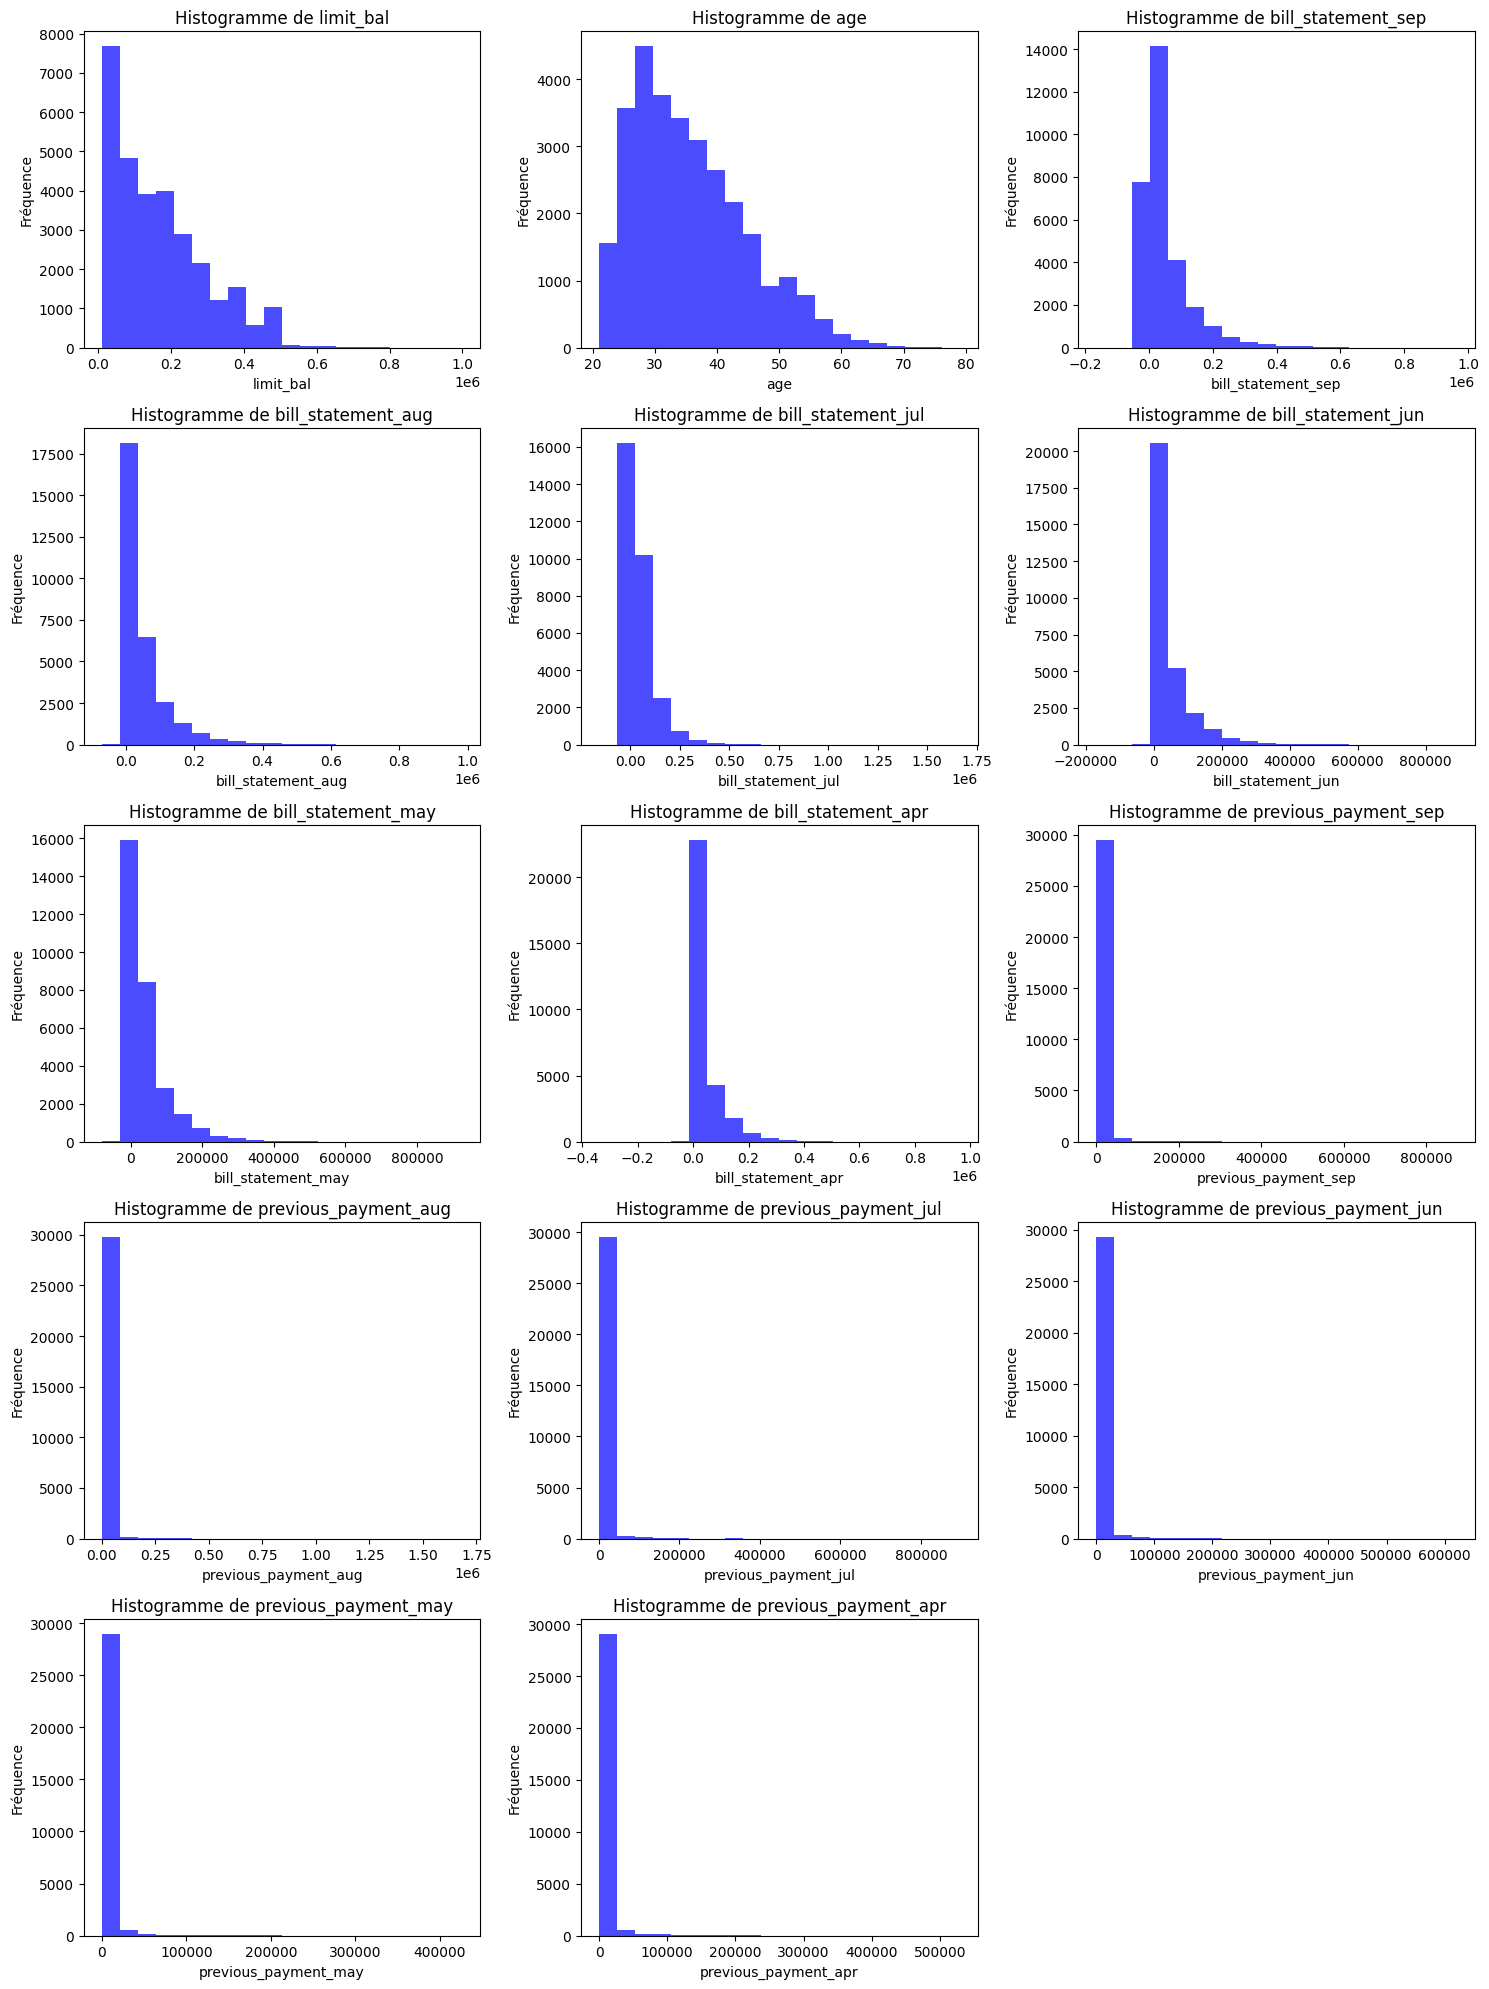

In [ ]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = df1.select_dtypes(include='number').drop(columns=['id'])

 # Afficher un histogramme pour chaque colonne numérique
plt.figure(figsize=(15, 20))  # Adapter la taille de la figure en fonction du nombre de colonnes
num_cols = len(numeric_columns.columns)

  # Créer une grille de sous-graphiques adaptée au nombre de colonnes numériques
for i, column in enumerate(numeric_columns.columns):
    plt.subplot(5, 3, i + 1)  # Adapté à 15 colonnes numériques
    plt.hist(df1[column], bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogramme de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()
plt.close()

**Boite à moustache/Boxplot pour les données numeriques/Quantitatives**

<ipython-input-14-4919c464a0e1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df1[column], palette="Set2")
<ipython-input-14-4919c464a0e1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df1[column], palette="Set2")
<ipython-input-14-4919c464a0e1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df1[column], palette="Set2")
<ipython-input-14-4919c464a0e1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same ef

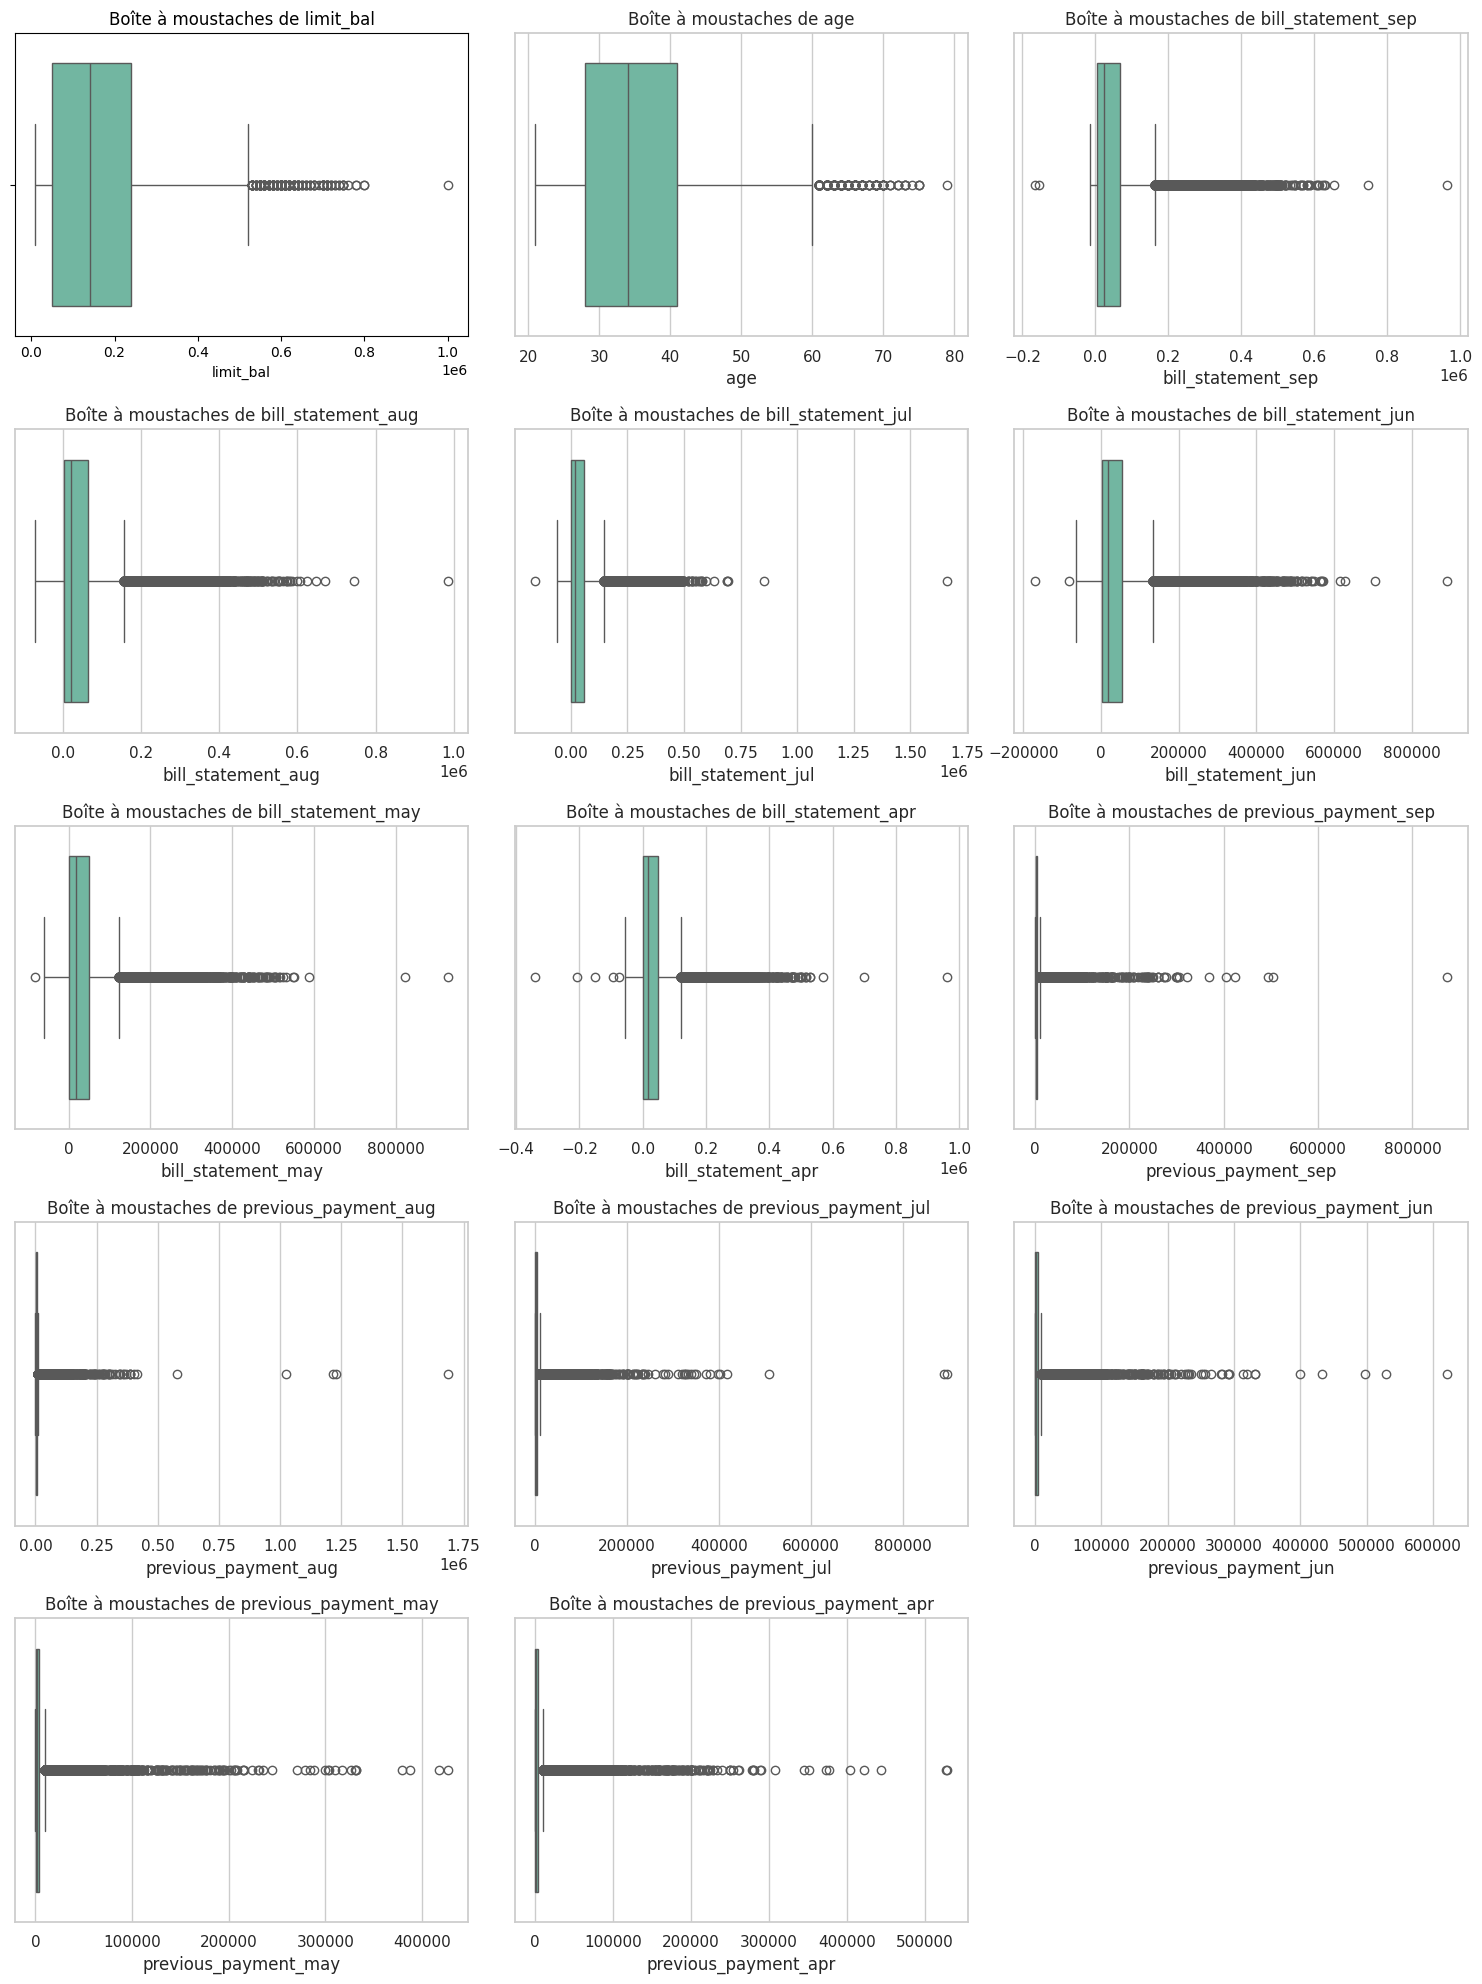

In [ ]:
# Afficher des boîtes à moustaches pour chaque colonne numérique (avec axes séparés)
plt.figure(figsize=(15, 20))  # Adapter la taille de la figure en fonction du nombre de colonnes
num_cols = len(numeric_columns.columns)
 # Créer une grille de sous-graphiques pour les boîtes à moustaches
for i, column in enumerate(numeric_columns.columns):
   plt.subplot(5, 3, i + 1)  # Adapté à 15 colonnes numériques
   sns.set(style="whitegrid")
   sns.boxplot(x=df1[column], palette="Set2")
   plt.title(f'Boîte à moustaches de {column}')
   plt.xlabel(column)

plt.tight_layout()
plt.show()
plt.close()

**Diagramme a barres pour les données catégoriques/qualitatives**

Analyse univariée de la colonne 'sex':

Fréquence des catégories :
sex
Female    0.603733
Male      0.396267
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


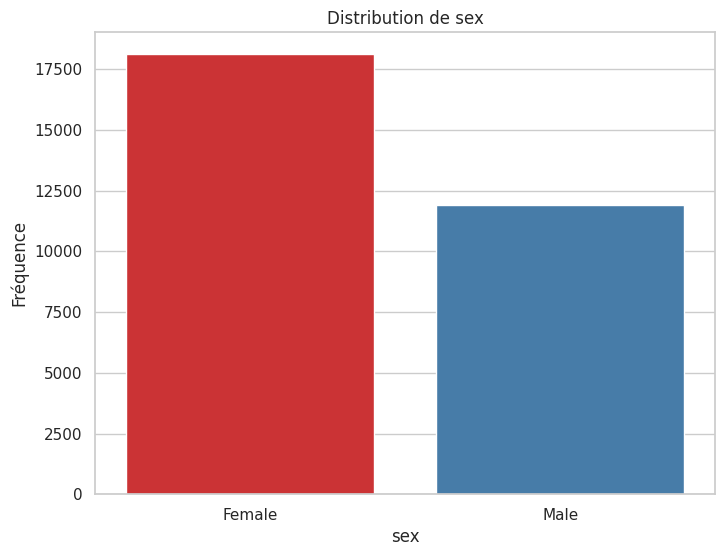

Analyse univariée de la colonne 'education':

Fréquence des catégories :
education
University         0.467667
Graduate school    0.352833
High school        0.163900
Others             0.015600
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


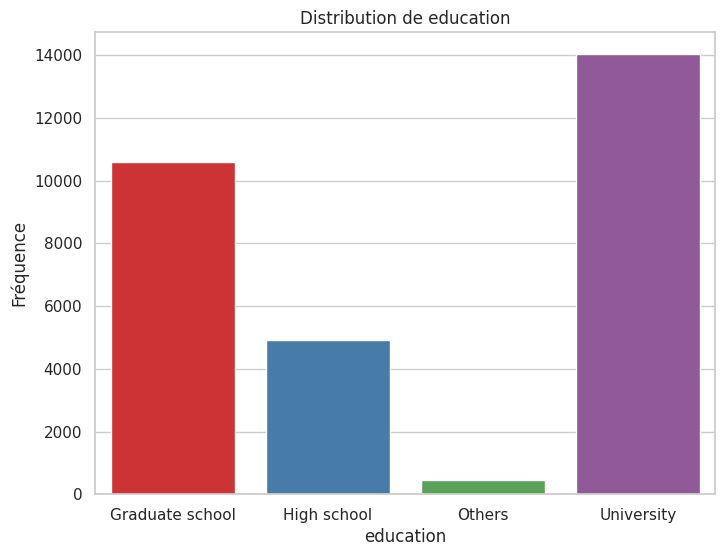

Analyse univariée de la colonne 'marriage':

Fréquence des catégories :
marriage
Single     0.532133
Married    0.455300
Others     0.012567
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


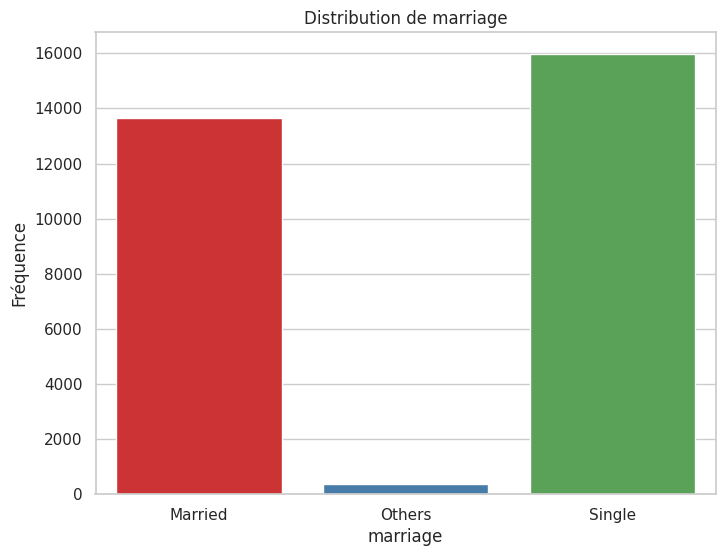

Analyse univariée de la colonne 'default_payment_next_month':

Fréquence des catégories :
default_payment_next_month
0    0.7788
1    0.2212
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


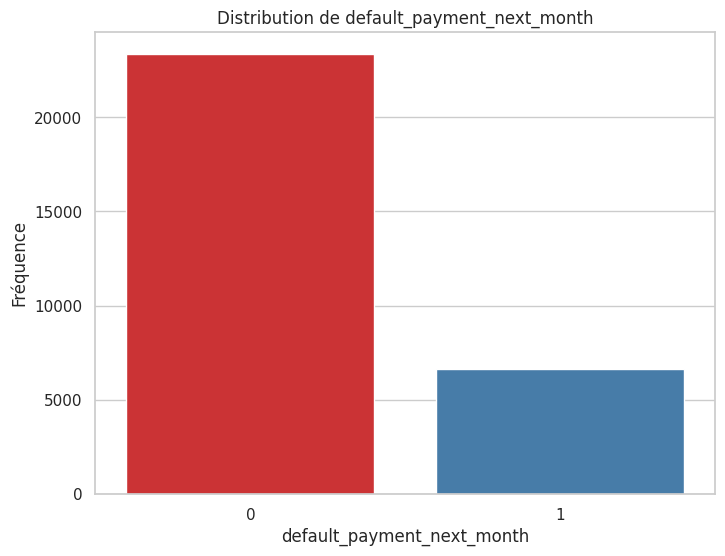

Analyse univariée de la colonne 'payment_status_sep':

Fréquence des catégories :
payment_status_sep
 0    0.491233
-1    0.189533
 1    0.122933
-2    0.091967
 2    0.088900
 3    0.010733
 4    0.002533
 5    0.000867
 8    0.000633
 6    0.000367
 7    0.000300
 9    0.000000
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


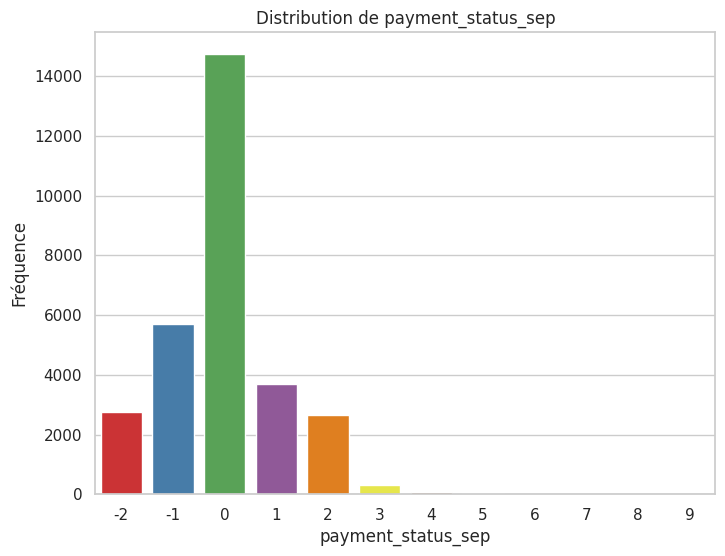

Analyse univariée de la colonne 'payment_status_aug':

Fréquence des catégories :
payment_status_aug
 0    0.524333
-1    0.201667
 2    0.130900
-2    0.126067
 3    0.010867
 4    0.003300
 1    0.000933
 5    0.000833
 7    0.000667
 6    0.000400
 8    0.000033
 9    0.000000
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


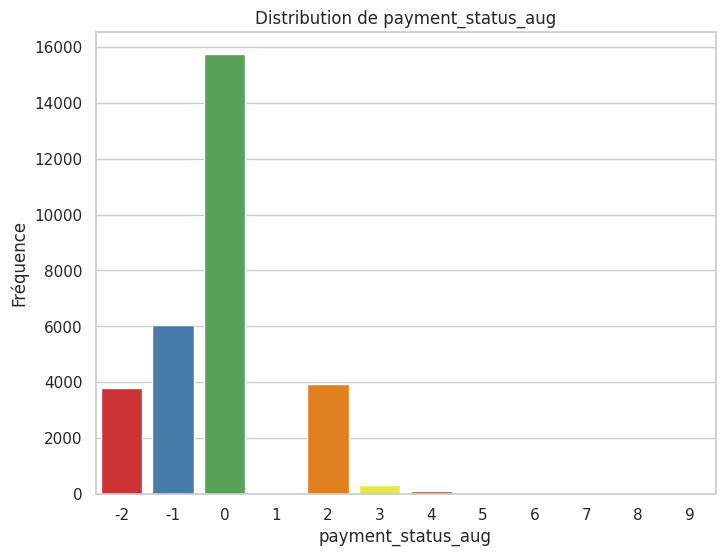

Analyse univariée de la colonne 'payment_status_jul':

Fréquence des catégories :
payment_status_jul
 0    0.525467
-1    0.197933
-2    0.136167
 2    0.127300
 3    0.008000
 4    0.002533
 7    0.000900
 6    0.000767
 5    0.000700
 1    0.000133
 8    0.000100
 9    0.000000
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


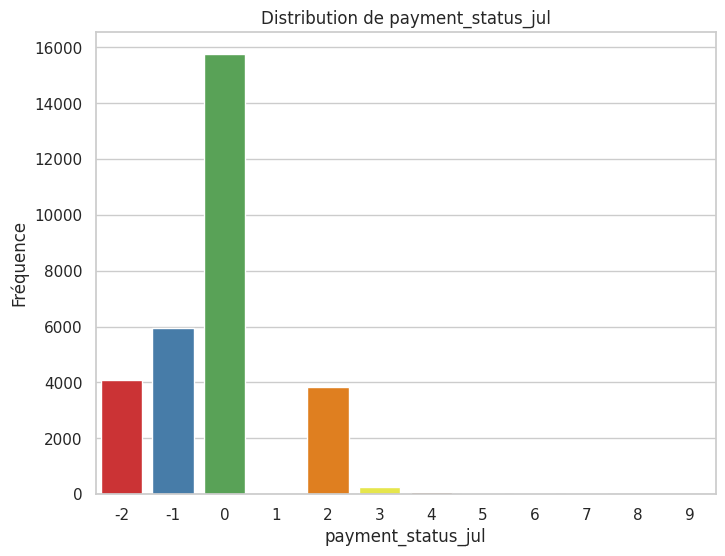

Analyse univariée de la colonne 'payment_status_jun':

Fréquence des catégories :
payment_status_jun
 0    0.548500
-1    0.189567
-2    0.144933
 2    0.105300
 3    0.006000
 4    0.002300
 7    0.001933
 5    0.001167
 6    0.000167
 1    0.000067
 8    0.000067
 9    0.000000
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


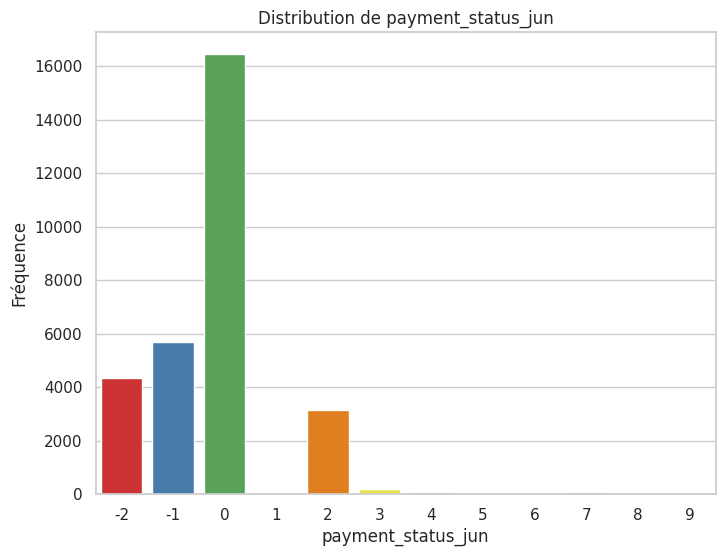

Analyse univariée de la colonne 'payment_status_may':

Fréquence des catégories :
payment_status_may
 0    0.564900
-1    0.184633
-2    0.151533
 2    0.087533
 3    0.005933
 4    0.002800
 7    0.001933
 5    0.000567
 6    0.000133
 8    0.000033
 1    0.000000
 9    0.000000
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


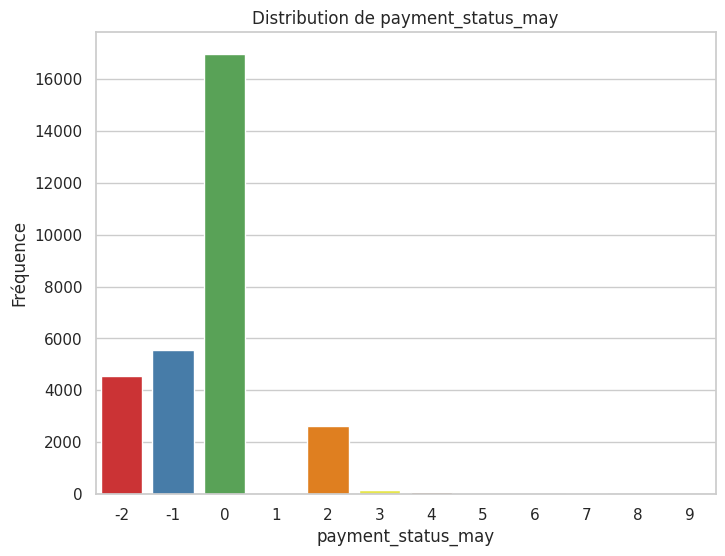

Analyse univariée de la colonne 'payment_status_apr':

Fréquence des catégories :
payment_status_apr
 0    0.542867
-1    0.191333
-2    0.163167
 2    0.092200
 3    0.006133
 4    0.001633
 7    0.001533
 6    0.000633
 5    0.000433
 8    0.000067
 1    0.000000
 9    0.000000
Name: proportion, dtype: float64



<ipython-input-15-62032a2c1b38>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x=column, palette='Set1')


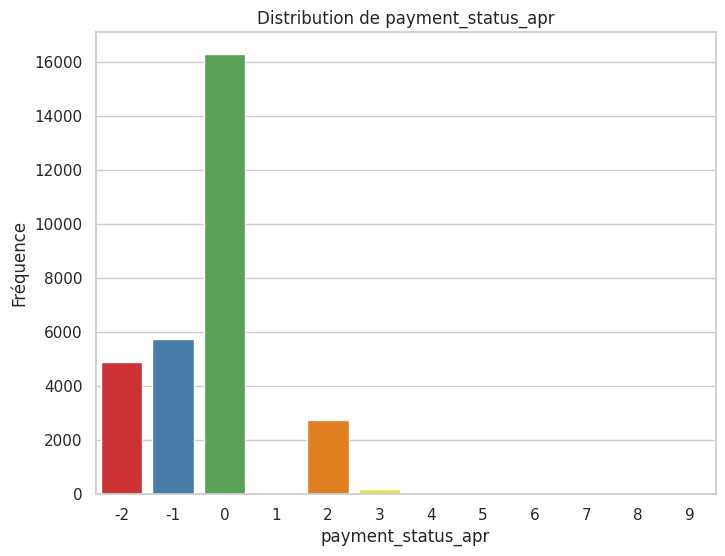

In [ ]:
# Colonnes à analyser
columns_to_analyze = [
      'sex', 'education', 'marriage', 'default_payment_next_month',
      'payment_status_sep', 'payment_status_aug', 'payment_status_jul',
      'payment_status_jun', 'payment_status_may', 'payment_status_apr'
  ]

# Diagrammes à barres
for column in columns_to_analyze:
    print(f"Analyse univariée de la colonne '{column}':\n")
     # Compter les occurrences de chaque catégorie
    value_counts = df1[column].value_counts(normalize=True)
    print(f"Fréquence des catégories :\n{value_counts}\n")
     # Afficher un graphique à barres pour visualiser la distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df1, x=column, palette='Set1')
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')
    plt.show()
    plt.close()


**Analyse Bivarié**

**Discrétisation des données**:La discrétisation des données consiste à transformer une variable continue en une variable catégorielle ou discrète, en regroupant ses valeurs dans des intervalles appelés bins.



affichez les variables numériques/catégorielles en fonction des variables catégorielles

In [ ]:
# affichez les distributions en discrétisant suivant une variable catégorielle
def plot_discretize_distributions(df, cat_var):
  # Créer des boîtes à moustaches pour chaque colonne numérique en les segmentant par sexe
  plt.figure(figsize=(15, 20))

  # Sélectionner uniquement les colonnes numériques
  numeric_columns = df.select_dtypes(include='number').drop(columns=['id'])

  # Créer une grille de sous-graphiques pour les boîtes à moustaches
  for i, column in enumerate(numeric_columns.columns):
      plt.subplot(5, 3, i + 1)  # Adapté à 15 colonnes numériques
      sns.set(style="whitegrid")
      sns.boxplot(data=df, x=column, y=cat_var, palette="Set2")
      plt.title(column + ' par ' + cat_var)
      plt.xlabel(column)
      plt.ylabel(cat_var)

  plt.tight_layout()
  plt.show()
  plt.close()

   # Colonnes à analyser par sexe
  columns_to_analyze = [
      'sex', 'education', 'marriage', 'default_payment_next_month',
      'payment_status_sep', 'payment_status_aug', 'payment_status_jul',
      'payment_status_jun', 'payment_status_may', 'payment_status_apr'
  ]
  columns_to_analyze.remove(cat_var)

  # Créer des graphiques à barres pour chaque colonne
  for column in columns_to_analyze:
      plt.figure(figsize=(10, 6))
      sns.countplot(data=df, x=column, hue=cat_var, palette='Set1')

      # Personnalisation du graphique
      plt.title(column + ' par ' + cat_var)
      plt.xlabel(column)
      plt.ylabel('Fréquence')
      plt.xticks(rotation=45)  # Faire pivoter les étiquettes de l'axe des x pour plus de lisibilité

      # Afficher le graphique
      plt.legend(title=cat_var)
      plt.show()
      plt.close()

<ipython-input-16-97650b273db9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=column, y=cat_var, palette="Set2")
<ipython-input-16-97650b273db9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=column, y=cat_var, palette="Set2")
<ipython-input-16-97650b273db9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=column, y=cat_var, palette="Set2")
<ipython-input-16-97650b273db9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variabl

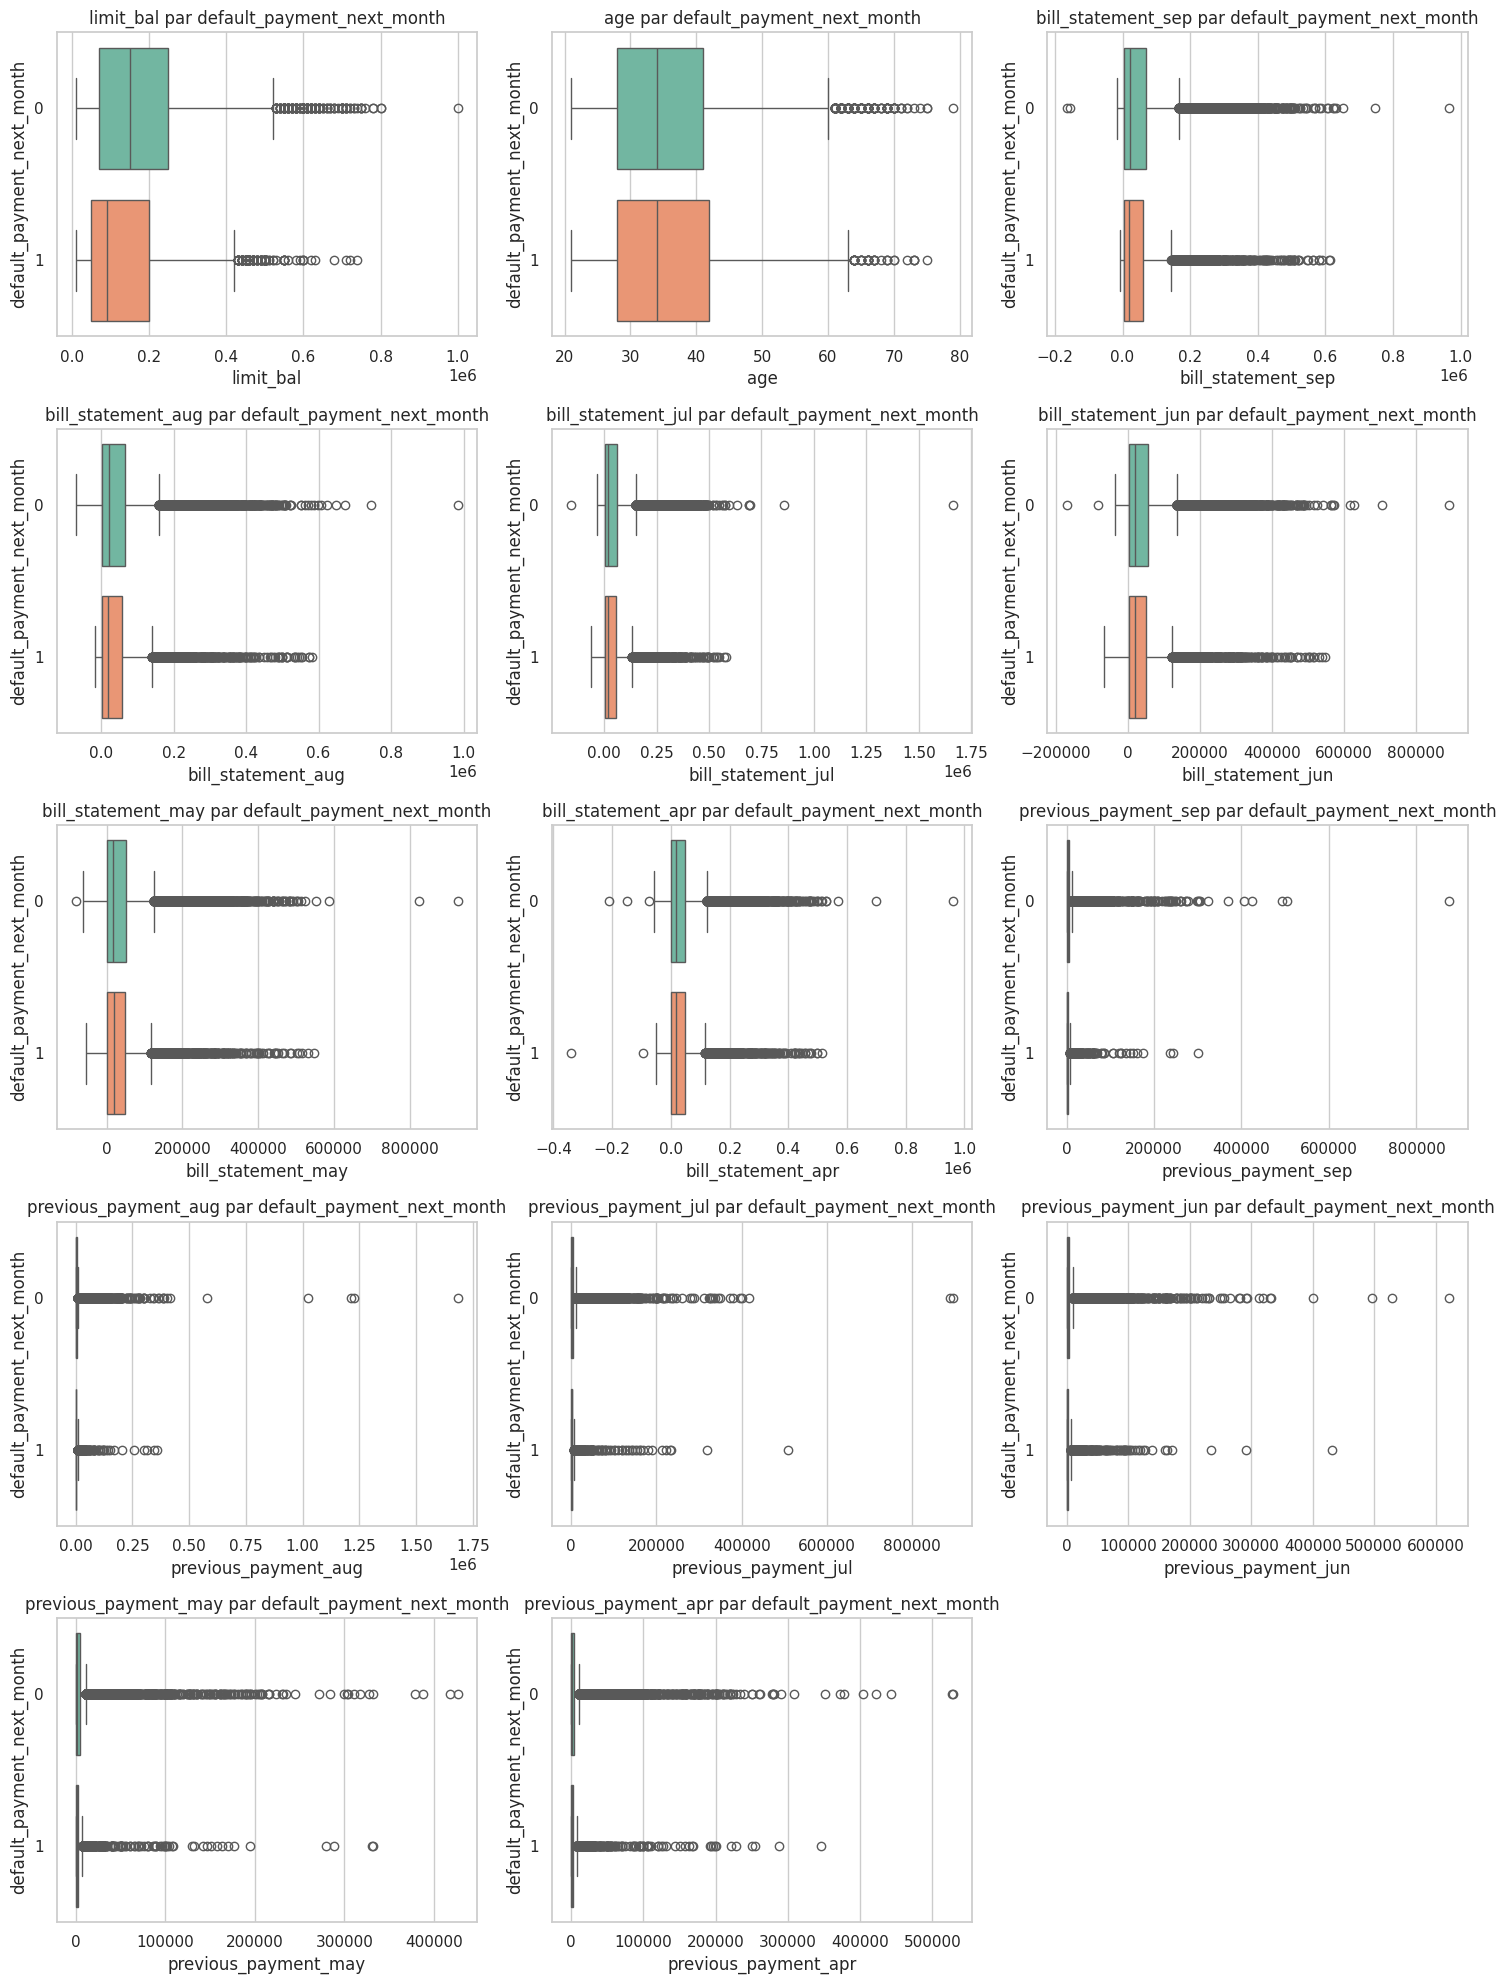

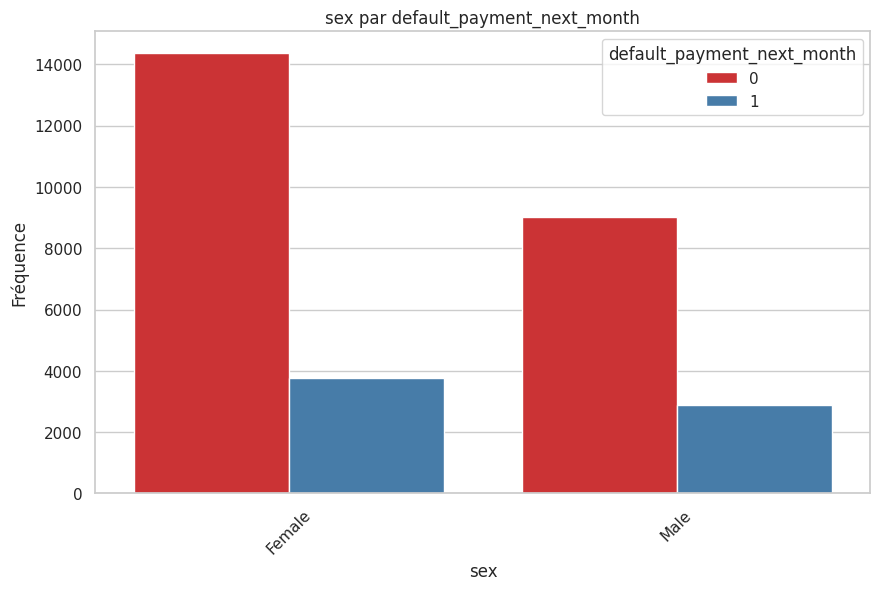

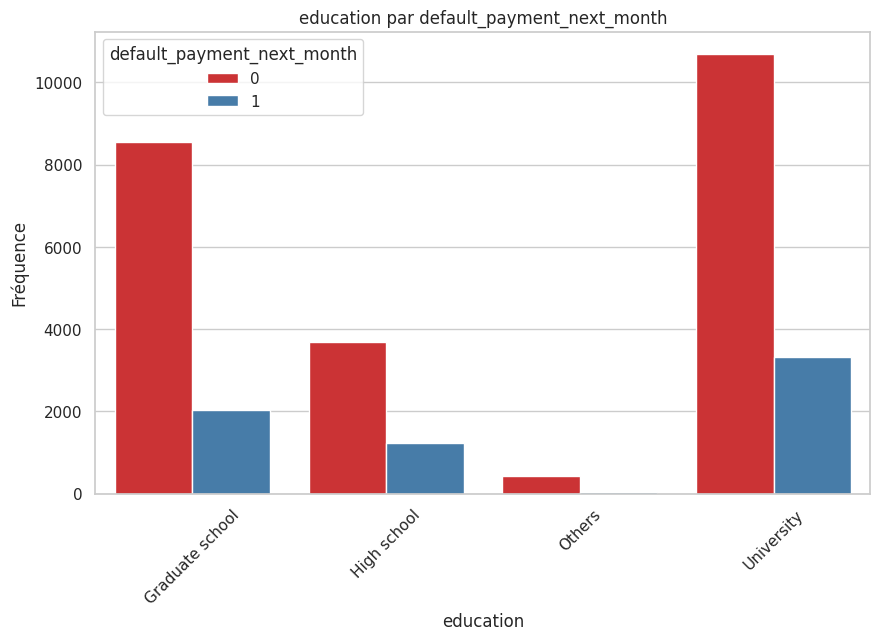

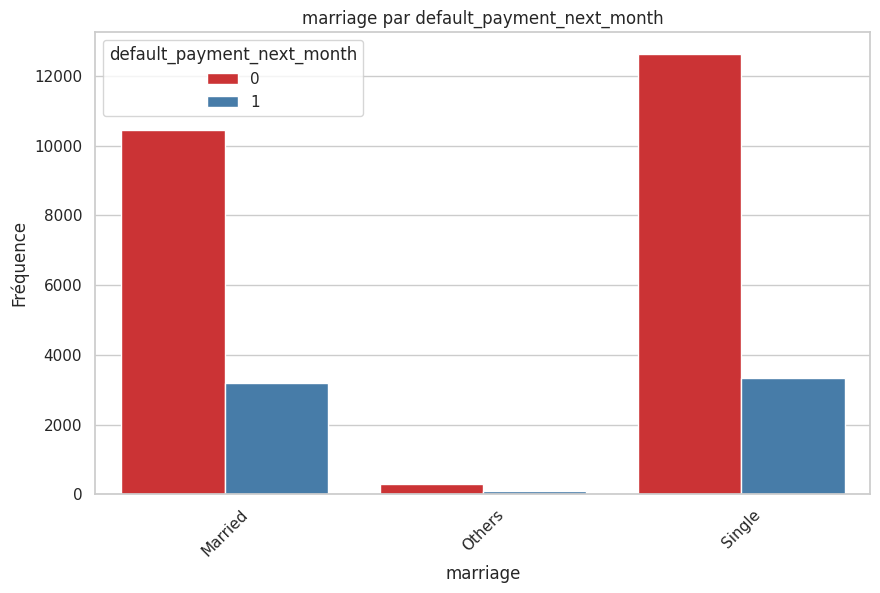

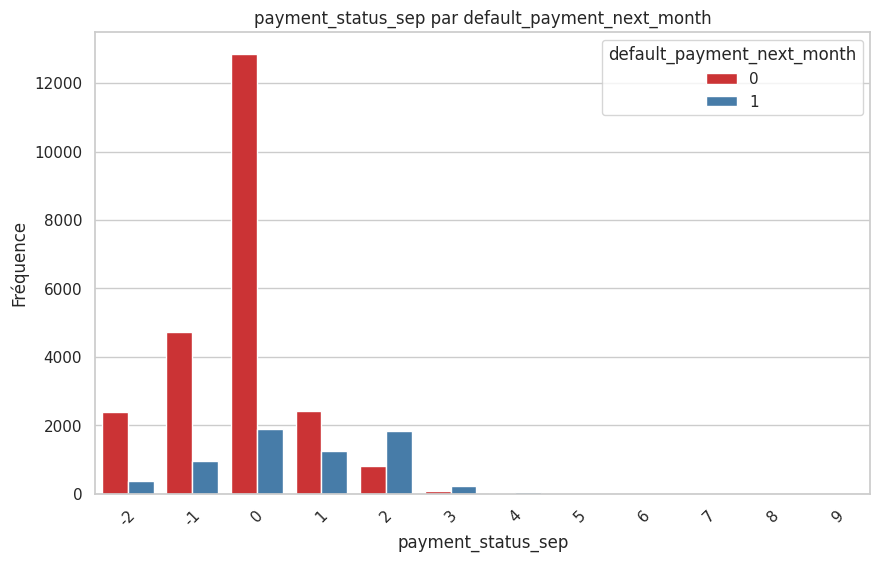

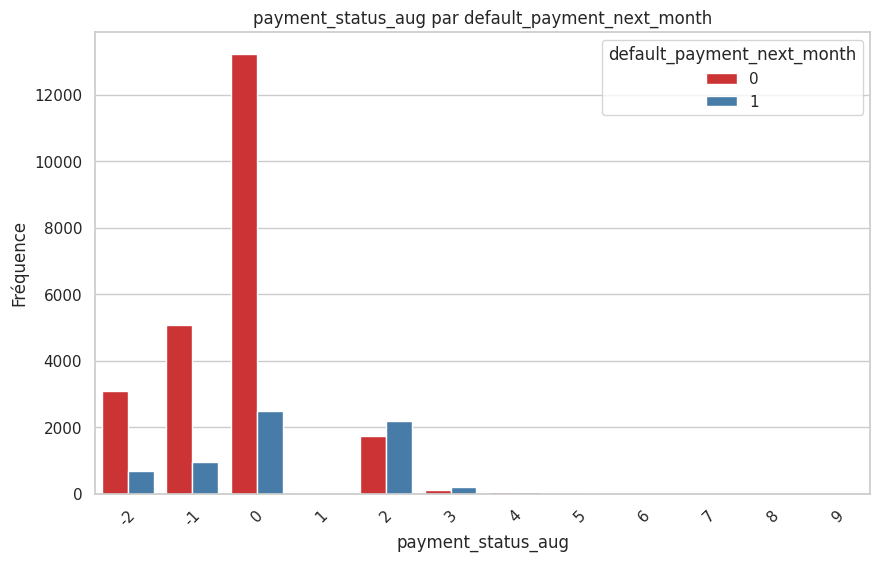

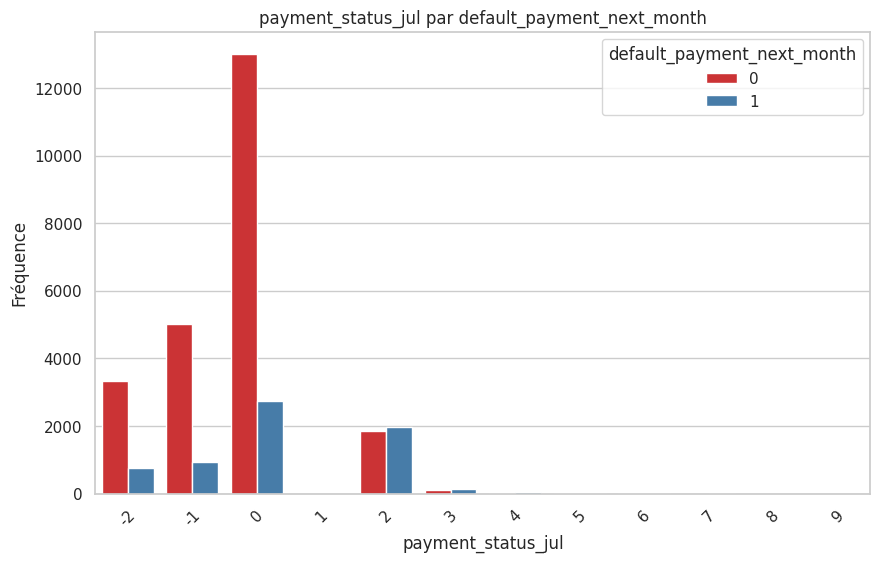

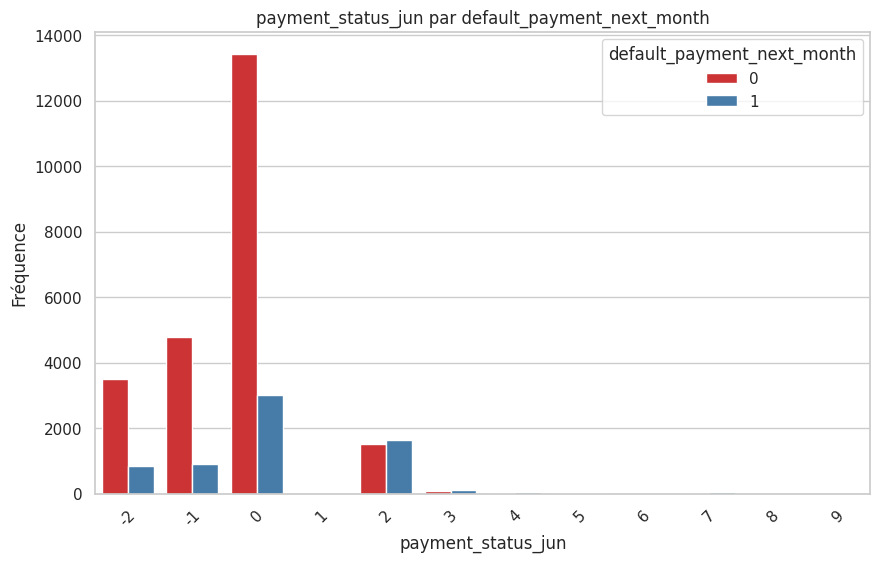

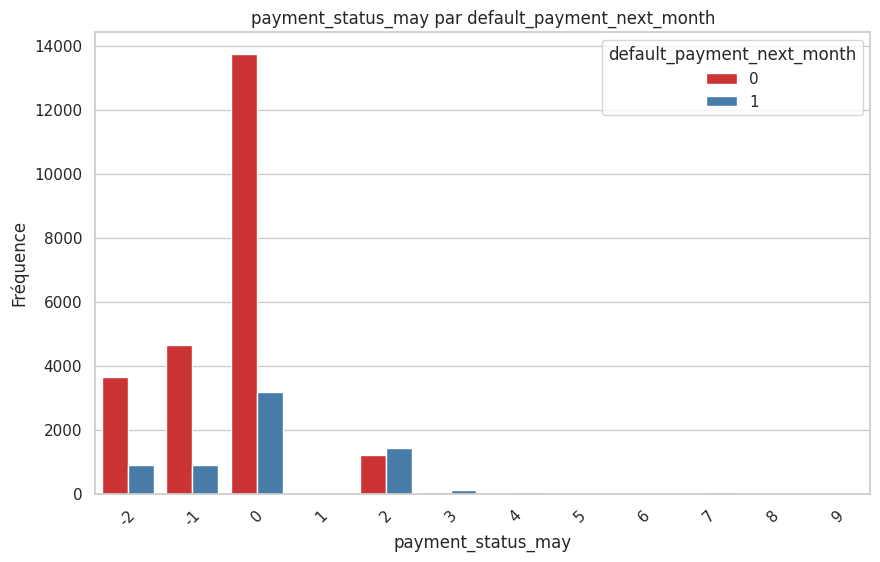

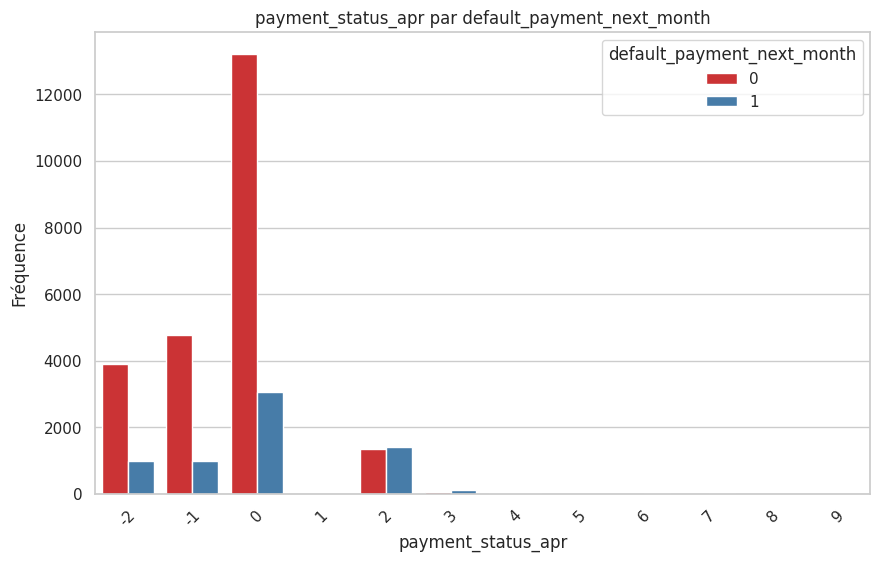

In [ ]:
plot_discretize_distributions(df1, 'default_payment_next_month')

Matrice de corrélation:La corrélation, c'est comme regarder si deux choses bougent ensemble.

In [ ]:
corrcoef = df1[[c for c in df1.columns if c not in ['id', 'sex', 'education', 'marriage']]].corr()
corrcoef

,limit_bal,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
limit_bal,1.000000,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,0.278314,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
age,0.144713,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,0.054283,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
payment_status_sep,-0.271214,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
payment_status_aug,-0.296382,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,0.235257,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
payment_status_jul,-0.286123,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,0.237295,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
payment_status_jun,-0.267460,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.202812,0.225816,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
payment_status_may,-0.249411,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,0.816900,0.206684,0.226913,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149
payment_status_apr,-0.235195,-0.048773,0.474553,0.575501,0.632684,0.716449,0.816900,1.000000,0.207373,0.226924,...,0.266356,0.290894,0.285091,-0.001496,-0.005223,0.005834,0.019018,-0.046434,-0.025299,0.186866
bill_statement_sep,0.285430,0.056239,0.187068,0.234887,0.208473,0.202812,0.206684,0.207373,1.000000,0.951484,...,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341,-0.019644
bill_statement_aug,0.278314,0.054283,0.189859,0.235257,0.237295,0.225816,0.226913,0.226924,0.951484,1.000000,...,0.892482,0.859778,0.831594,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256,-0.014193


In [ ]:
def plot_correlation_matrix(corr_mat):
  sns.set(style="white")
  mask = np.zeros_like(corr_mat, dtype=bool)
  mask[np.triu_indices_from(mask)] = True
  fig, ax = plt.subplots(figsize=(12, 10))
  cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
  sns.heatmap(
      corr_mat, mask=mask, cmap=cmap, annot=True,
      fmt=".1f", vmin=-1, vmax=1, center=0, square=True,
      linewidths=.5, cbar_kws={"shrink": .5}, ax=ax
  )
  ax.set_title("Matrice de Correlation", fontsize=16)
  sns.set(style="darkgrid")

Rouge :corrélation positive(elles montent ensemble)

Bleu :corrélation negative((elles vont en sens inverse)

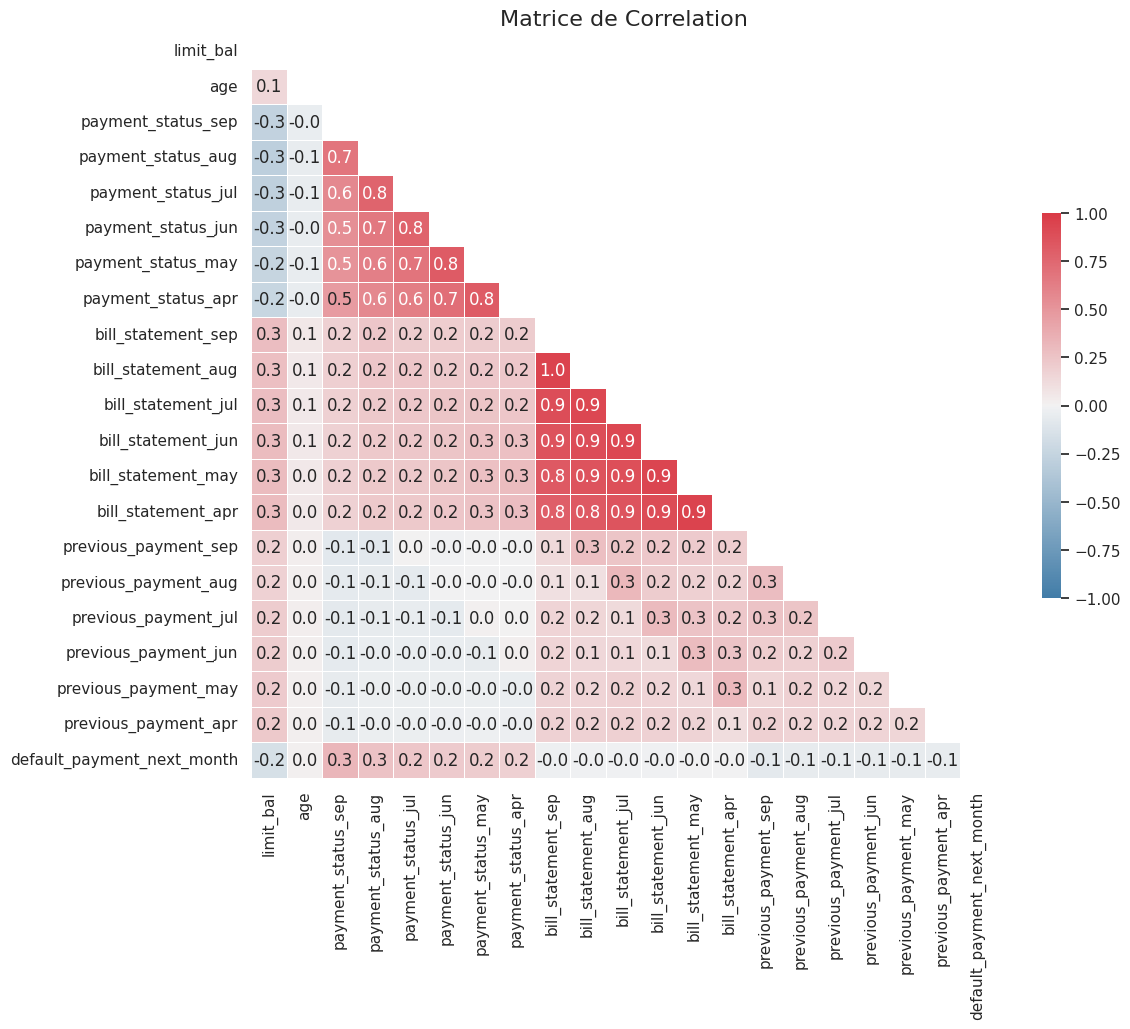

In [ ]:
plot_correlation_matrix(corrcoef)

**montant du prêt en fonction du statut maritale**

<Axes: xlabel='marriage', ylabel='limit_bal'>

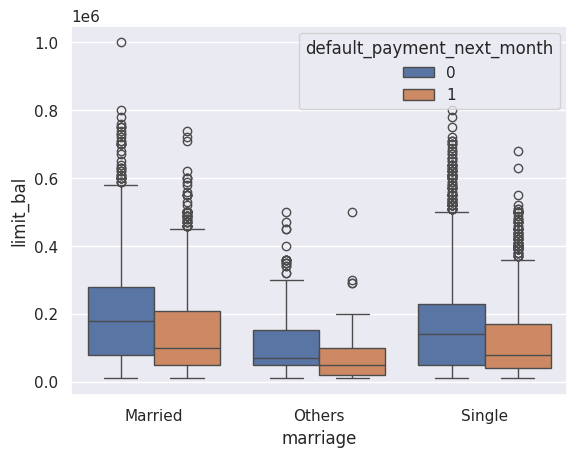

In [ ]:
sns.boxplot(data=df1, x='marriage', y='limit_bal',hue='default_payment_next_month')

**Pourcentage de defaut de payment selon une catégorie**

In [ ]:
def pct_default_by_category(df, cat_var):
  # Pourcentage de défauts de paiement
  ax = df.groupby(cat_var)["default_payment_next_month"] \
  .value_counts(normalize=True) \
  .unstack() \
  .plot(kind="barh", stacked="True")
  ax.set_title("Pourcentage de défauts de paiement",
  fontsize=16)
  ax.legend(title="Defaut de paiement", bbox_to_anchor=(1,1))
  plt.show()

<ipython-input-22-59112ad3f35d>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df.groupby(cat_var)["default_payment_next_month"] \


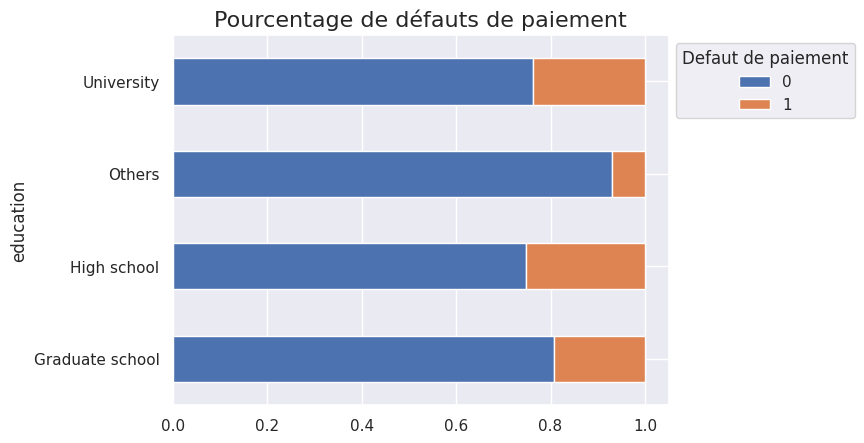

In [ ]:
pct_default_by_category(df1, 'education')

SWEETVIZ?

In [ ]:
pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 40.8 MB/s eta 0:00:00


In [ ]:
import sweetviz as sv

In [ ]:
my_report = sv.analyze(df1)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
#df_test = pd.read_csv('/root/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1/UCI_Credit_Card.csv', delimiter=',')
#my_analyse=sv.analyze(source=df_test,target_feat="default.payment.next.month")
#my_analyse.show_html()

#division

In [ ]:
X = df1.drop(['id','default_payment_next_month'], axis=1)
y = df1['default_payment_next_month']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Afficher la taille des ensembles d'entraînement, de validation et de test
print("Taille de l'ensemble d'entraînement :", X_train.shape, y_train.shape)
print("Taille de l'ensemble de validation :", X_val.shape, y_val.shape)
print("Taille de l'ensemble de test :", X_test.shape, y_test.shape)
print("")
print("Distribution des classes dans chaque ensemble ----")
print(f"Total: {y.value_counts(normalize=True).values}")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_val.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")


Taille de l'ensemble d'entraînement : (18000, 23) (18000,)
Taille de l'ensemble de validation : (6000, 23) (6000,)
Taille de l'ensemble de test : (6000, 23) (6000,)

Distribution des classes dans chaque ensemble ----
Total: [0.7788 0.2212]
Train: [0.77877778 0.22122222]
Valid: [0.77883333 0.22116667]
Test: [0.77883333 0.22116667]


#**Pipeline de donnée**

In [ ]:
#séparation des variables numeriques et des variables catégorielles
cat_features = ['sex', 'education', 'marriage']
num_features = [c for c in X_train if c not in cat_features]
num_features

['limit_bal',
 'age',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

In [ ]:
# Création de transformateurs pour les colonnes catégorielles et numériques
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))  # Utilisation de l'encodage one-hot, sparse_output remplace sparse
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normalisation des caractéristiques numériques
])

# Création du transformateur de colonnes en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Création du modèle (dans cet exemple, nous utilisons un RandomForestClassifier)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Création du pipeline complet
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model',rf_model)
                                  ])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_payment_jul',
                                                   'previous_payment_jun',
                                                   'previous_payment_may',
                                                   'previous_payment_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_payment_jul',
                                                   'previous_payment_jun',
                                                   'previous_payment_may',
                                                   'previous_payment_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [ ]:
# Fonction d'évaluation des modèles
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    """
    Function for creating a performance report of a classification model.

    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect,
        show_plot must be True.

    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    """

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, _ = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ["Negative", "Positive"]

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 20 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle("Evaluation de la Performance du Modèle", fontsize=16)

        # plot 1: confusion matrix ----

        # preparing more descriptive labels for the confusion matrix
        cm_counts = [f"{val:0.0f}" for val in cm.flatten()]
        cm_percentages = [f"{val:.2%}" for val in cm.flatten()/np.sum(cm)]
        cm_labels = [f"{v1}\n{v2}" for v1, v2 in zip(cm_counts,cm_percentages)]
        cm_labels = np.asarray(cm_labels).reshape(2,2)

        sns.heatmap(cm, annot=cm_labels, fmt="", linewidths=.5, cmap="Greens",
                    square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": "center", "va": "center"})
        ax[0].set(xlabel="Predicted label",
                  ylabel="Actual label", title="Confusion Matrix")
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        # plot 2: ROC curve ----

        metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name="")
        ax[1].set_title("ROC Curve")
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), "ro",
                   markersize=8, label="Decision Point")
        ax[1].plot([0, 1], [0, 1], "r--")

        if show_pr_curve:

            metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[2], name="")
            ax[2].set_title("Precision-Recall Curve")

    stats = {
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "precision": metrics.precision_score(y_test, y_pred),
        "recall": metrics.recall_score(y_test, y_pred),
        "specificity": (tn / (tn + fp)),
        "f1_score": metrics.f1_score(y_test, y_pred),
        "cohens_kappa": metrics.cohen_kappa_score(y_test, y_pred),
        "matthews_corr_coeff": metrics.matthews_corrcoef(y_test, y_pred),
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "average_precision": metrics.average_precision_score(y_test, y_pred_prob)
    }

    return stats



{'accuracy': 0.8215,
 'precision': 0.674863387978142,
 'recall': 0.37226827430293896,
 'specificity': 0.9490691204793494,
 'f1_score': 0.47984458474987857,
 'cohens_kappa': 0.38278435142218936,
 'matthews_corr_coeff': 0.407489288045542,
 'roc_auc': 0.7687949388097636,
 'pr_auc': 0.550213546737198,
 'average_precision': 0.5467372545887665}

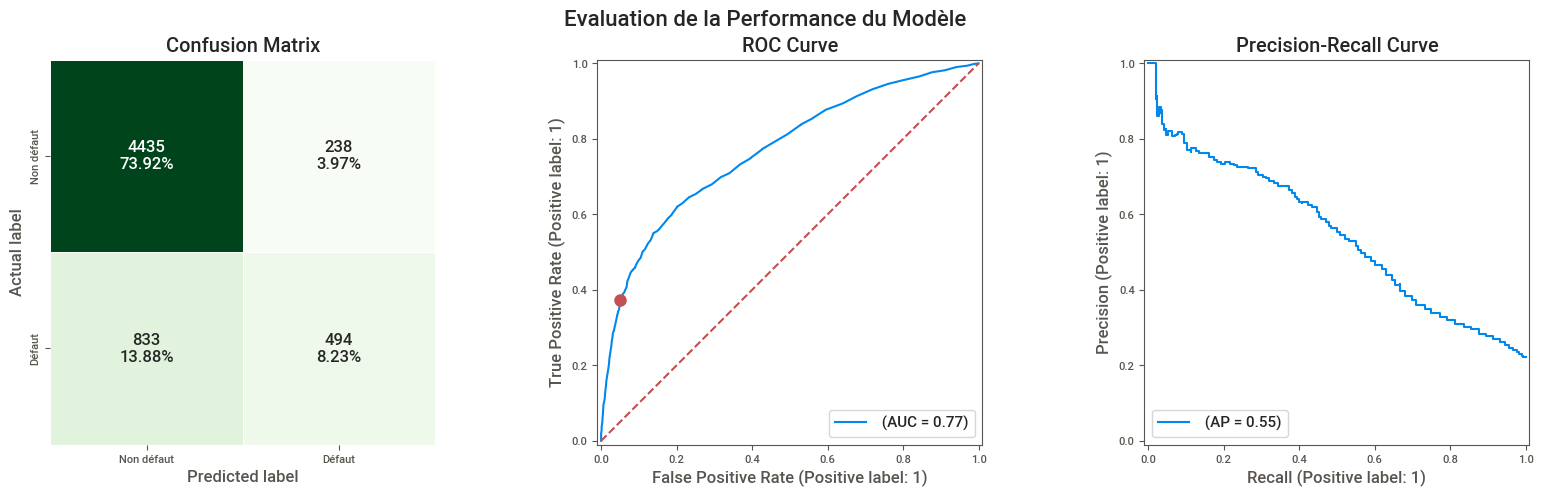

In [ ]:
LABELS = ["Non défaut", "Défaut"]
performance_evaluation_report(pipeline, X_test, y_test, show_plot=True, labels=LABELS ,show_pr_curve=True)